# The Best Neighborhood in Pittsburgh

## Final Ranking
In this notebook, we combine three sub-metrics developed independently by our team members to produce a single, group-level ranking of Pittsburgh neighborhoods. Each sub-metric focuses on a different aspect of "bestness":
- **Ivan** --- Food: count of restaurants per neighborhood  
- **Ruoyu** --- Safety: crime incidents per 100 residents (lower is better)  
- **Yang** --- Education-Income index: a combined score based on education level and income  

Each group member's personal notebook are included in their respective folders.

Our goal is to normalize these scores to a common 0~100 scale, decide on a weighting scheme, and then compute a combined score that allows us to identify the single "best" neighborhood in Pittsburgh according to our data driven metric.

## The Data
We extracted CSV files from each member's preprocessed data into the `Final_Notebook_Data` folder for final metric calculations. Each exported dataset contains only two columns: neighborhood and score.

The individual data cleaning and feature engineering steps for each metric are documented in our three personal notebooks. In this notebook, we work with the preprocessed CSV files and focus exclusively on **cleaning, normalizing, combining the three scores, and producing a final ranking.**

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the three CSV files from Final_Notebook_Data folder
food_df = pd.read_csv('Final_Notebook_Data/ivan_food_score.csv')
safety_df = pd.read_csv('Final_Notebook_Data/ruoyu_safety_score.csv')
education_df = pd.read_csv('Final_Notebook_Data/yang_education_score.csv')

## Individual Metric Results

Before combining the metrics, let's first review each team member's individual findings. This helps establish the foundation for our composite ranking.

### Food 

                 neighborhood  score
1   Central Business District    175
2            South Side Flats    102
3                 North Shore     83
4               North Oakland     76
5             Central Oakland     68
6                   Shadyside     67
7              Strip District     66
8                  Bloomfield     66
9         Squirrel Hill South     62
10      Central Lawrenceville     55


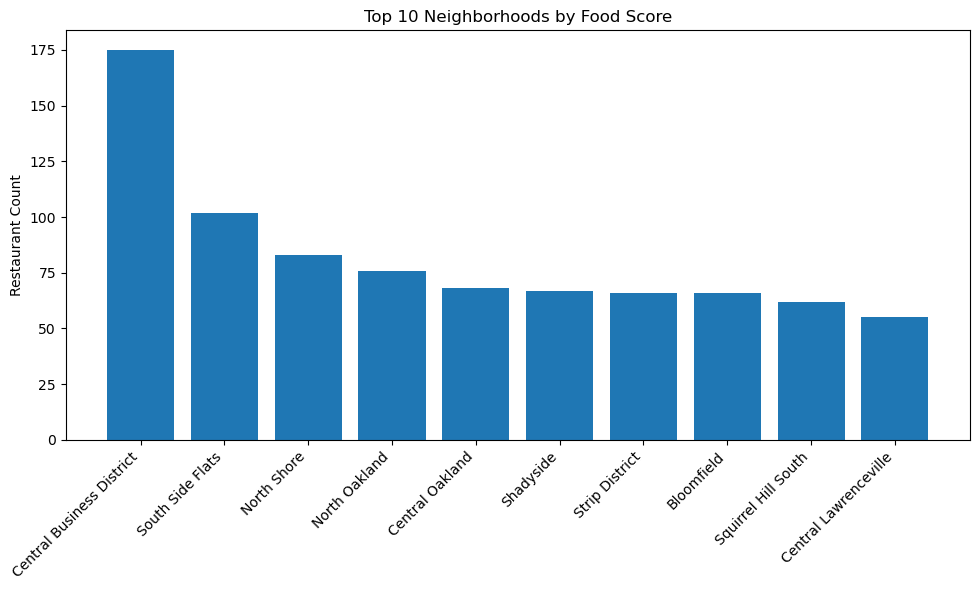

In [72]:
food_display = pd.read_csv('Final_Notebook_Data/ivan_food_score.csv')
food_display_sorted = food_display.sort_values('score', ascending=False).reset_index(drop=True)
food_display_sorted.index = food_display_sorted.index + 1
print(food_display_sorted.head(10).to_string())

# Visualize 
top10_food = food_display_sorted.head(10)
plt.figure(figsize=(10,6))
plt.bar(top10_food['neighborhood'], top10_food['score'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Restaurant Count')
plt.title('Top 10 Neighborhoods by Food Score')
plt.tight_layout()
plt.show()

### Safety 

           neighborhood         score
1       Mt. Oliver Boro   2971.462195
2             Troy Hill  11038.107753
3          Mount Oliver  19565.217391
4    Central North Side  27178.423237
5        Swisshelm Park  32936.802974
6   Squirrel Hill North  36062.103035
7         New Homestead  36279.547790
8       Stanton Heights  39592.522579
9           Summer Hill  43912.678421
10           Banksville  46526.697771


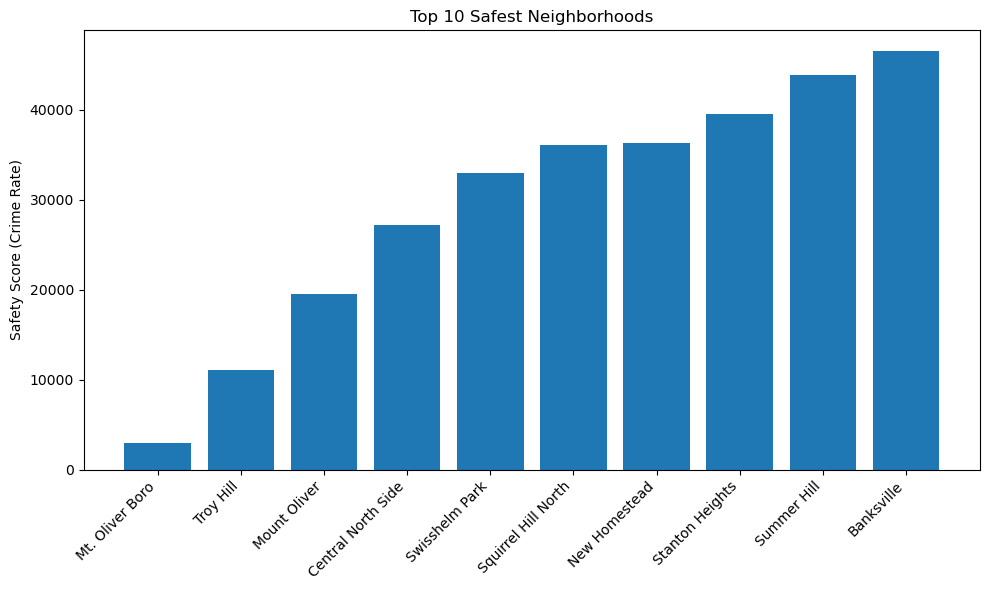

In [73]:
# display safety results
safety_display = pd.read_csv('Final_Notebook_Data/ruoyu_safety_score.csv')
safety_display_sorted = safety_display.sort_values('score', ascending=True).reset_index(drop=True)
safety_display_sorted.index = safety_display_sorted.index + 1
print(safety_display_sorted.head(10).to_string())

# Visualize safety 
top10_safety = safety_display_sorted.head(10)
plt.figure(figsize=(10, 6))
plt.bar(top10_safety['neighborhood'], top10_safety['score'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Safety Score (Crime Rate)')
plt.title('Top 10 Safest Neighborhoods')
plt.tight_layout()
plt.show()

### Education-Income Index 

           neighborhood     score
1           South Shore  0.904417
2         Regent Square  0.826564
3   Squirrel Hill North  0.823226
4          Point Breeze  0.804642
5        Strip District  0.729355
6         Highland Park  0.717362
7   Squirrel Hill South  0.711556
8           North Shore  0.687365
9        Allegheny West  0.684996
10            Shadyside  0.679692


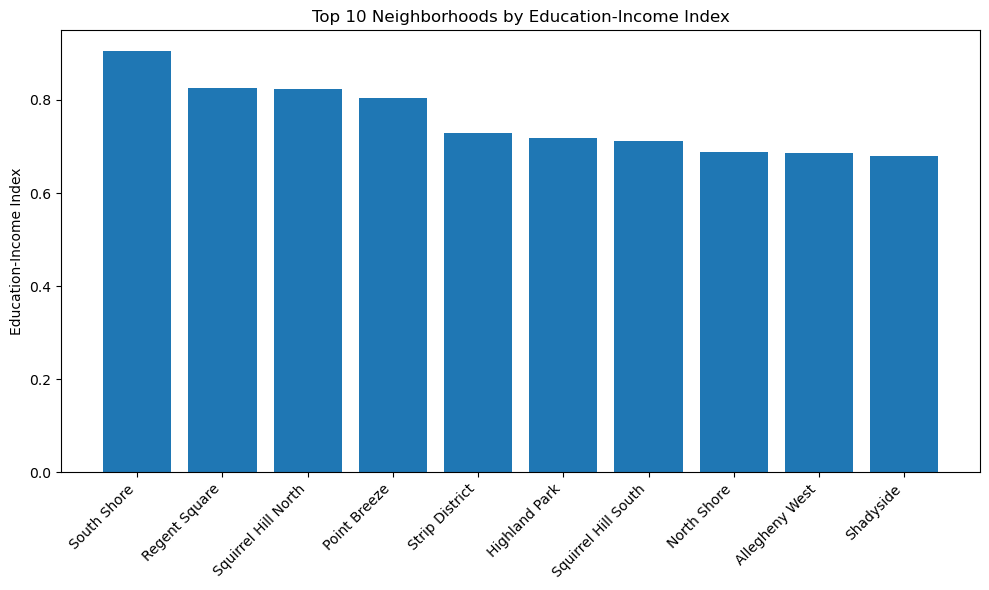

In [74]:
#  display education-income index 
education_display = pd.read_csv('Final_Notebook_Data/yang_education_score.csv')
education_display_sorted = education_display.sort_values('score', ascending=False).reset_index(drop=True)
education_display_sorted.index = education_display_sorted.index + 1
print(education_display_sorted.head(10).to_string())

# Visualize 
top10_education = education_display_sorted.head(10)
plt.figure(figsize=(10, 6))
plt.bar(top10_education['neighborhood'], top10_education['score'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Education-Income Index')
plt.title('Top 10 Neighborhoods by Education-Income Index')
plt.tight_layout()
plt.show()

---

## Combined Metric Process

Now that we've reviewed each individual metric, we'll then combine them into a single comprehensive ranking. 



## 1. Clean Data

Before we can combine the three metrics, we need to ensure the data is clean and consistent:

Here we Keep only neighborhoods that appear in all three datasets to ensure fair comparison, and remove any rows with missing data


In [75]:
# Rename score columns 
food_df.columns = ['neighborhood', 'food_score']
safety_df.columns = ['neighborhood', 'safety_score']
education_df.columns = ['neighborhood', 'education_score']

# convert crime rate to #of crimes/ 100k
safety_df['safety_score'] = safety_df['safety_score'] / 100

# keep only neighborhoods present in all three
merged = food_df.merge(safety_df, on='neighborhood', how='inner')
merged = merged.merge(education_df, on='neighborhood', how='inner')

# Remove rows with missing data
merged = merged.dropna()

print(f"Neighborhoods appearing in all 3 datasets ]: {len(merged)}")
print(merged.head(10))

Neighborhoods appearing in all 3 datasets ]: 67
                neighborhood  food_score  safety_score  education_score
0  Central Business District         175   4912.068966         0.494142
1           South Side Flats         102   3035.282899         0.560153
2                North Shore          83  18185.365854         0.687365
3              North Oakland          76    495.938346         0.599985
4            Central Oakland          68    898.144967         0.321219
5                  Shadyside          67    646.880991         0.679692
6             Strip District          66   4725.568942         0.729355
7                 Bloomfield          66   1004.037375         0.524776
8        Squirrel Hill South          62    486.784690         0.711556
9      Central Lawrenceville          55    918.324607         0.431113


### Handle Outliers in Safety Score

Based on the output above, we observe that some neighborhoods have extremely high crime rates that could distort our normalization process. 

To address this, then we cap the safety scores at the 96th percentile. This can prevent a few extreme outliers from compressing the scores of the majority of neighborhoods into a narrow range, and still preserve the relative differences among most neighborhoods.

In [76]:
# Remove outliers in safety score that has extreme values
percentile_96 = merged['safety_score'].quantile(0.96)
print(f"96th percentile of safety score: {percentile_96:.2f}")
print(f"Neighborhoods above 96th percentile: {(merged['safety_score'] > percentile_96).sum()}")
# Cap extreme values 
merged['safety_score_capped'] = merged['safety_score'].clip(upper=percentile_96)

96th percentile of safety score: 5119.89
Neighborhoods above 96th percentile: 3


## 2. Normalize Scores to [0, 100]

We decided to normalize all scores to a common scale of 0 to 100. This approach ensures that each metric contributes proportionally to the final score, regardless of their original units or ranges.

In [77]:
# Normalize all scores to [0, 100]
def normalize(series):
    return ((series - series.min()) / (series.max() - series.min())) * 100

merged['food_norm'] = normalize(merged['food_score'])
merged['safety_norm'] = normalize(merged['safety_score_capped'])  
merged['education_norm'] = merged['education_score'] * 100  # scale to 100


## 3.1 Calculate Final Score 

Next we can obtain the final score with our combined metric:

**Weights:**
- Education: **1**
- Food: **1**  
- Safety: **2**

**Formula:**

### $$\text{Final Score} = \text{Education} + \text{Food} - 2 \times \text{Safety}$$

*Note: Higher Safety Score means higher crime rate, so we subtract it.*

In [78]:

# Calculate final score with weights: Safety=2, Education=1, Food=1
merged['final_score'] = merged['education_norm'] + merged['food_norm'] -2 * merged['safety_norm'] 

# Sort by final score 
result = merged.sort_values('final_score', ascending=False).reset_index(drop=True)
result['rank'] = range(1, len(result) + 1)
print("TOP 10 BEST NEIGHBORHOODS IN PITTSBURGH")
print(result[['rank', 'neighborhood', 'final_score', 'safety_norm', 'education_norm', 'food_norm']].head(10).to_string(index=False))

TOP 10 BEST NEIGHBORHOODS IN PITTSBURGH
 rank        neighborhood  final_score  safety_norm  education_norm  food_norm
    1 Squirrel Hill South    91.185531     7.513776       71.155612  35.057471
    2 Squirrel Hill North    90.148110     4.995295       82.322607  17.816092
    3       North Oakland    87.708940     7.696502       59.998495  43.103448
    4           Shadyside    84.480961    10.709622       67.969169  37.931034
    5       Regent Square    65.801489     8.714810       82.656396   0.574713
    6        Point Breeze    65.658313     9.127063       80.464163   3.448276
    7          Bloomfield    54.155520    17.839184       52.477566  37.356322
    8       Highland Park    53.421009    11.169072       71.736164   4.022989
    9          Greenfield    53.143547     7.292158       59.681886   8.045977
   10           Troy Hill    47.759749     0.000000       43.162047   4.597701


## 3.2 Visualization: Top 10 Neighborhoods by Final Score

To better communicate our results, we plot the combined final score for the top 10 neighborhoods. This makes it easier to see how close the top scoring neighborhoods are to each other and whether there is a clear best one.

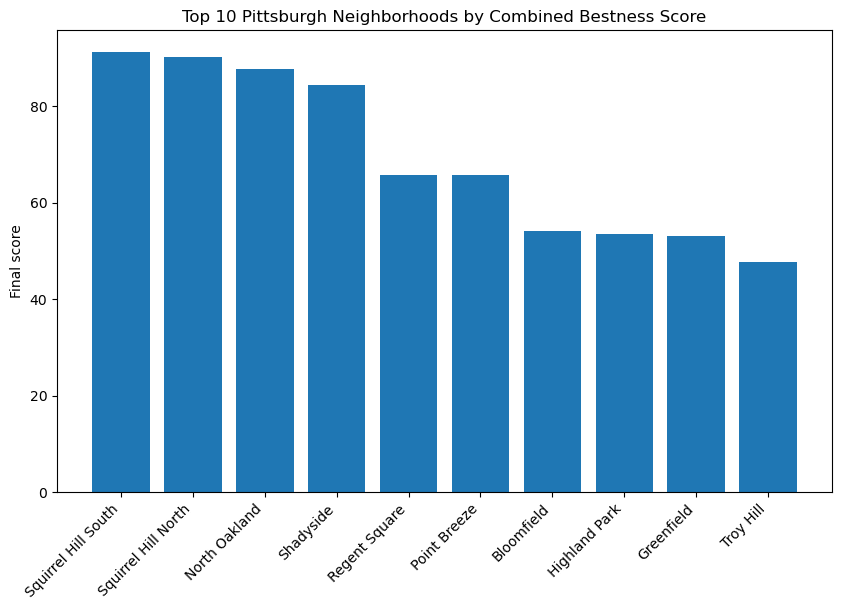

In [79]:
top10 = result.head(10)

plt.figure(figsize=(10, 6))
plt.bar(top10['neighborhood'], top10['final_score'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Final score')
plt.title('Top 10 Pittsburgh Neighborhoods by Combined Bestness Score')
plt.show()

## 4.1 Conclusion


Based on our combined metric 

$$\text{Final Score} = \text{Education} + \text{Food} - 2 \times \text{Safety}$$

**Squirrel Hill South** emerges as the best neighborhood in Pittsburgh among the neighborhoods that appear in three datasets.

From a data perspective, Squirrel Hill South performs consistently well across all three dimensions:

- It has one of the highest normalized **education-income** scores.  
- It has a relatively high **food** score, indicating a rich restaurant presence.  
- Its capped and normalized **safety** score is better (lower crime rate) than many other highly educated or food-rich neighborhoods.  


## 4.2 Reflection
- Yang: For me, this result does not fully match my personal preference from my perspective. My favorite neighborhood in Pittsburgh is **North Oakland**, mainly because it is very very close to the campus and makes my daily life as a student much more convenient. Being able to walk to classes and libraries is an important factor for me, and this type of convenience is not captured in our metric.
At the same time, I also really like **Squirrel Hill**, especially because it has so many great restaurants and a lively food scene. Although these subjective qualities do not appear directly in our metric, they significantly shape my personal impression of a neighborhood.
This comparison highlights how a data-driven metric can identify a statistically strong neighborhood, while personal preferences often depend on practical considerations and individual experiences that extend beyond what the data measures.
"

- Ivan: The result doesn't really align with my personal preference. I like North Oakland the most because it's walkable to most of the campus, and honestly it's simply because I live here now :)

- Ruoyu: My favorite neighborhood is also Squirrel Hill South because I live in there!"
    "Life in this community is very convenient, especially with the wide variety of food options. There are large supermarkets such as Giant Eagle, as well as specialty Asian markets like Panda Supermarket, along with many Chinese restaurants and other international dining choices. Whether I want to buy fresh ingredients to cook at home or go out with friends to enjoy authentic cuisine, I can always find the right place nearby."
    "Beyond food and shopping, Squirrel Hill South is also a very safe neighborhood. I often come home late at night, and I still feel a strong sense of security walking through the streets. The area is clean, quiet, and residents treat each other with respect, which makes the environment comfortable and welcoming. "

This aligns with our impressions: Squirrel Hill South feels like a balanced neighborhood with walkable streets, diverse food options, and a strong residential community.